In [6]:
import os, sys
# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)
import time
import jax.numpy as jnp
import scs
import numpy as np
from scipy.sparse import csc_matrix
from l2ws.algo_steps import k_steps_eval_osqp, k_steps_train_osqp, create_projection_fn, lin_sys_solve, k_steps_train_osqp
import jax.scipy as jsp
import pytest
import matplotlib.pyplot as plt
from l2ws.osqp_model import OSQPmodel
import cvxpy as cp
from jax import vmap
from functools import partial
from examples.osc_mass import multiple_random_osc_mass_osqp
from examples.mpc import multiple_random_mpc_osqp, solve_many_probs_cvxpy
from scipy.spatial import distance_matrix
# from examples.ista import sol_2_obj_diff, solve_many_probs_cvxpy
from l2ws.utils.nn_utils import get_nearest_neighbors

In [7]:
N_train = 500
N_test = 50
N = N_train + N_test
factor, P, A, q_mat, theta_mat = multiple_random_mpc_osqp(N, 
                                                            T=10,
                                                            nx=10,
                                                            nu=5,
                                                            sigma=1,
                                                            rho=1,
                                                            Ad=None,
                                                            Bd=None,
                                                            seed=42)
train_inputs, test_inputs = theta_mat[:N_train, :], theta_mat[N_train:, :]
z_stars_train, z_stars_test = None, None
q_mat_train, q_mat_test = q_mat[:N_train, :], q_mat[N_train:, :]

# solve the QPs
z_stars, objvals = solve_many_probs_cvxpy(P, A, q_mat)
z_stars_train, z_stars_test = z_stars[:N_train, :], z_stars[N_train:, :]

train_unrolls = 10
input_dict = dict(algorithm='osqp',
                    q_mat_train=q_mat_train,
                    q_mat_test=q_mat_test,
                    A=A,
                    factor=factor,
                    train_inputs=theta_mat[:N_train, :],
                    test_inputs=theta_mat[N_train:, :],
                    train_unrolls=train_unrolls,
                    nn_cfg={'intermediate_layer_sizes': [300]},
                    jit=True)
osqp_model = OSQPmodel(input_dict)


                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 02 03:25:58 PM: Your problem has 400 variables, 3 constraints, and 650 parameters.
(CVXPY) May 02 03:25:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 02 03:25:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 02 03:25:58 PM: Compiling problem (target solver=ECOS).
(CVXPY) May 02 03:25:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) May 02 03:25:58 PM: Applying reduction Dcp2Cone
(CVXPY) May 02 03:25:58 PM: Applying reduction CvxAttr2Constr
(CVXP

distances [[1.06493963 1.41291272 1.18942571 ... 1.32197421 1.12481809 0.91419763]
 [1.18362708 1.57775313 1.64069833 ... 1.18539897 1.00252435 1.08103933]
 [1.16351418 1.50162238 1.14478679 ... 1.06911304 1.27490596 1.03177794]
 ...
 [1.08205891 1.33621425 1.20173071 ... 1.05002479 0.99867487 1.10754626]
 [0.95659648 1.49752069 1.57154921 ... 0.82405647 1.04412472 1.38772882]
 [1.40211368 1.01367503 1.34599285 ... 1.40253019 1.46631559 1.00679057]]
indices [114 443  78  38 185 112 289 411 334  71  84 489 277 301 442  60 301 296
 346 312 167 473  88  55 339  88 276 449 357  94 134 301 255 458 393 450
 335 364 269 496 265 281  55 393 169 148 415 484  15 312]
best val [0.51472543 0.52999388 0.42020389 0.34265499 0.5297106  0.48974182
 0.65396367 0.48205791 0.54535919 0.52429401 0.40609968 0.609309
 0.41325347 0.38363161 0.44472559 0.42283574 0.60011006 0.55757818
 0.64964125 0.46716921 0.58468658 0.5935379  0.45450945 0.58991319
 0.57223245 0.41420986 0.46806994 0.31406487 0.57503102 0.5

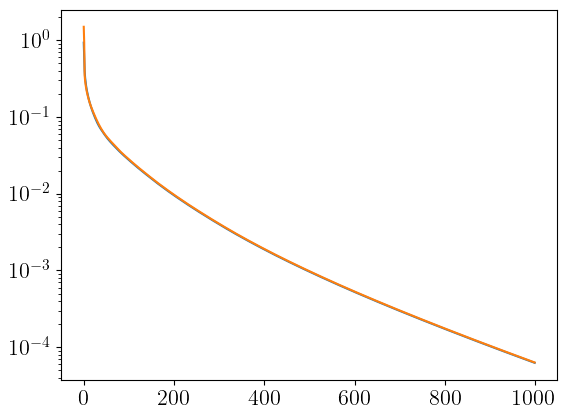

In [8]:
# full evaluation on the test set with nearest neighbor
k = 1000
nearest_neighbors_z = get_nearest_neighbors(train_inputs, test_inputs, z_stars_train)
nn_eval_out = osqp_model.evaluate(k, nearest_neighbors_z,
                                    q_mat_test, z_stars=z_stars_test,
                                    fixed_ws=True, tag='test')
# nn_z_all = nn_eval_out[1][3]
# nn_rel_objs = batch_rel_mat(nn_z_all, b_mat_test, objvals_test).mean(axis=1)
nn_losses = nn_eval_out[1][1].mean(axis=0)

# full evaluation on the test set
init_eval_out = osqp_model.evaluate(
    k, test_inputs, q_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
init_test_losses = init_eval_out[1][1].mean(axis=0)
# init_z_all = init_eval_out[1][3]

# import pdb
# pdb.set_trace()

plt.plot(init_test_losses)
plt.plot(nn_losses)
plt.yscale('log')
plt.show()

In [11]:
# train the osqp_model
# call train_batch without jitting
params, state = osqp_model.params, osqp_model.state
num_epochs = 1000
train_losses = jnp.zeros(num_epochs)
for i in range(num_epochs):
    train_result = osqp_model.train_full_batch(params, state)
    loss, params, state = train_result
    train_losses = train_losses.at[i].set(loss)

osqp_model.params, osqp_model.state = params, state

# full evaluation on the test set
# k = 200
final_eval_out = osqp_model.evaluate(
    k, test_inputs, q_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
final_test_losses = final_eval_out[1][1].mean(axis=0)
# final_z_all = init_eval_out[1][3]

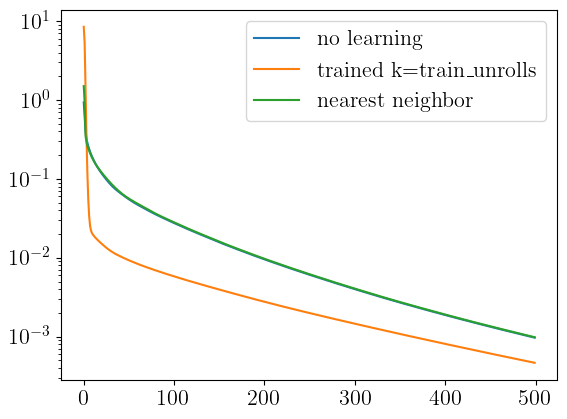

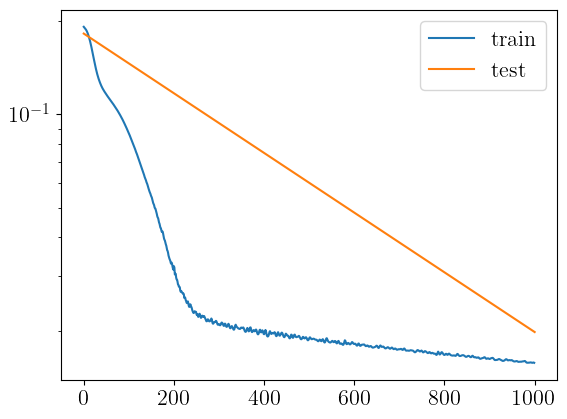

In [13]:
plt.plot(init_test_losses[:500], label='no learning')
plt.plot(final_test_losses[:500], label='trained k={train_unrolls}')
plt.plot(nn_losses[:500], label='nearest neighbor')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('fixed point residual')
plt.legend()
plt.show()

plt.title('losses')
plt.plot(train_losses, label='train')
init_test_loss = init_test_losses[train_unrolls]
final_test_loss = final_test_losses[train_unrolls]
test_losses = np.array([init_test_loss, final_test_loss])
epochs_array = np.array([0, num_epochs])
plt.plot(epochs_array, test_losses, label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()